In [10]:
from MyViT.utils import MRISegDataset
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor, ToPILImage

import matplotlib.pyplot as plt


In [11]:
IMAGE_SIZE = (1,128,128)
NUM_PATCHES = 32

train_image_dataset = MRISegDataset('data/mri_data_seg/images/train/', transform=ToTensor(),image_shape = IMAGE_SIZE[1])
train_image_loader  = DataLoader(train_image_dataset, shuffle=False, batch_size=128)

train_mask_dataset = MRISegDataset('data/mri_data_seg/masks/train/', transform=ToTensor(),image_shape = IMAGE_SIZE[1])
train_mask_loader  = DataLoader(train_mask_dataset, shuffle=False, batch_size=128)


500


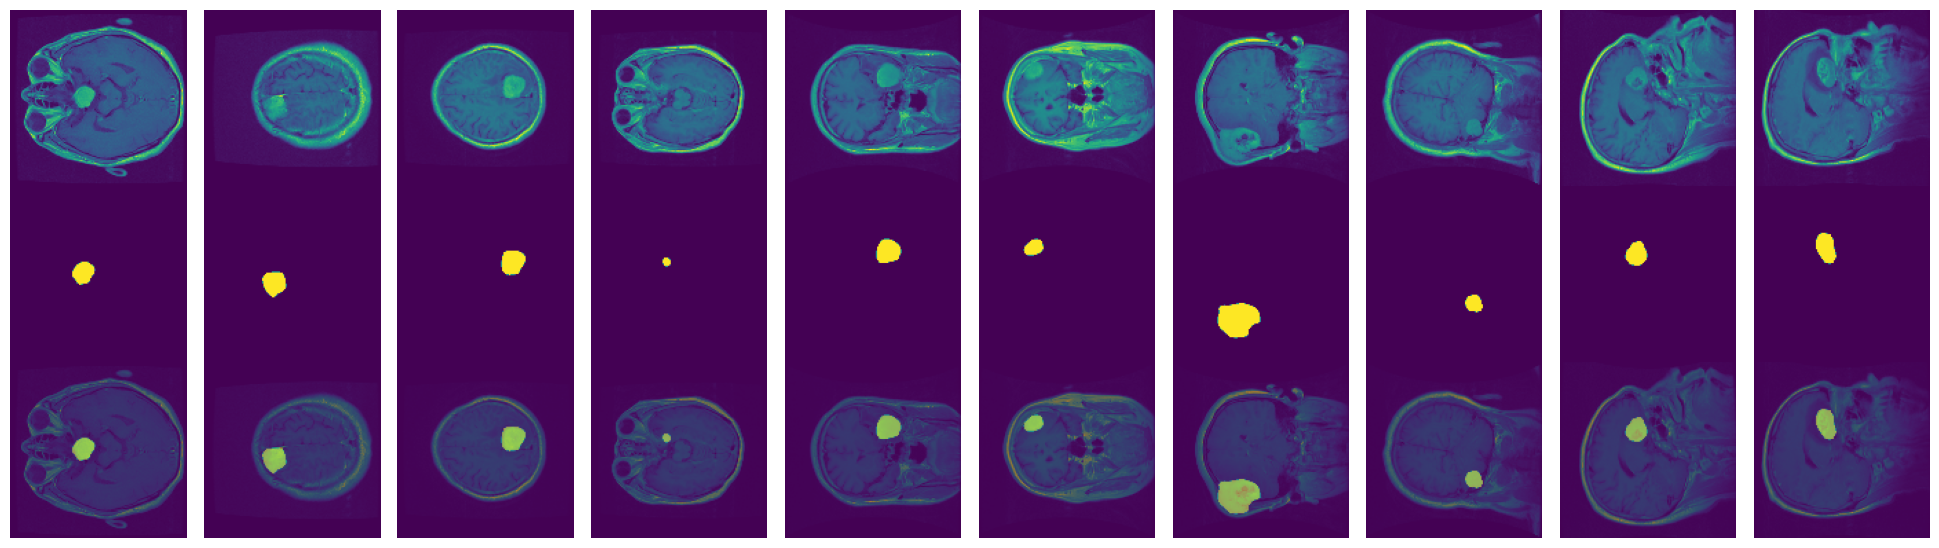

In [12]:
# import numpy as np
import random
num_train_tumor_files = len(train_image_dataset)
# print(num_train_tumor_files)
train_files_to_display = random.sample(range(num_train_tumor_files), k=10)
# print(train_files_to_display)
img_count = 0
image_and_mask_dict = {}

plt.figure(figsize=(25,6))
plt.subplots_adjust(wspace=0, hspace=0,bottom=0)
for i, (image, mask) in enumerate(zip(train_image_dataset,train_mask_dataset)):
    # print(i, (i  in train_files_to_display))
    if (i in train_files_to_display):
        img_count = img_count+1
        # Convert the tensor back to a PIL image for display
        to_pil = ToPILImage()
        image_pil = to_pil(image)
        mask_pil = to_pil(mask)

        # Display the image
        plt.subplot(3,10,img_count)
        plt.imshow(image_pil)
        plt.axis('off')

        plt.subplot(3,10,img_count+10)
        plt.imshow(mask_pil)
        plt.axis('off')


        plt.subplot(3,10,img_count+20)
        plt.imshow(image_pil)
        plt.imshow(mask_pil,alpha=0.5)
        plt.axis('off')
        
    image_and_mask_dict[image] = mask
        

print(len(image_and_mask_dict))





In [ ]:
import os
# Import necessary classes from the datasets module
from datasets import Dataset, DatasetDict, Image

# Lists to store file paths for training and validation images and masks
image_paths_train = []
label_paths_train = []

image_paths_validation = []
label_paths_validation = []

# Iterate through sorted files in the training images directory
train_images_path = 'data/mri_data_seg/images/train/'
train_masks_path = 'data/mri_data_seg/masks/train/'
test_images_path = 'data/mri_data_seg/images/test/'
test_masks_path = 'data/mri_data_seg/masks/test/'

for file1 in sorted(os.listdir(train_images_path)):
    image_paths_train.append(train_images_path + file1)

for file2 in sorted(os.listdir(train_masks_path)):
    label_paths_train.append(train_masks_path + file2)

for file3 in sorted(os.listdir(test_images_path)):
    image_paths_validation.append(test_images_path + file3)

for file4 in sorted(os.listdir(test_masks_path)):
    label_paths_validation.append(test_masks_path + file4)


image_paths_train = sorted(image_paths_train)
label_paths_train = sorted(label_paths_train)
image_paths_validation = sorted(image_paths_validation)
label_paths_validation = sorted(label_paths_validation)


def create_dataset(image_paths, label_paths):
    dataset = Dataset.from_dict({"pixel_values": sorted(image_paths),"label": sorted(label_paths)})
    # dataset = dataset.cast_column("pixel_values",Image())
    # dataset = dataset.cast_column("label",Image())
    return dataset

#  Create Dataset objects for training and validation
train_dataset = create_dataset(image_paths_train, label_paths_train)
# print(train_dataset['pixel_values'])
validation_dataset = create_dataset(image_paths_validation, label_paths_validation)

split_dataset = train_dataset.train_test_split(test_size=0.2)
# print(split_dataset)
split_dataset["train"] = split_dataset["train"]
split_dataset["val"] = split_dataset["test"]
split_dataset["test"] = validation_dataset

id2label = {
    0:  'bg',
    1:  'tumor',
}
for id, label in id2label.items():
    print(id,label)
    label2id = { label: id  }
n_classes = len(id2label)

dataset = DatasetDict({
    "train": split_dataset["train"],
    "validation": split_dataset["val"] ,
    "test":split_dataset["test"],
    "id2label": label2id,
    "n_classes":n_classes
  }
)

del split_dataset

import datasets
from datasets import DatasetDict

dataset_hf = DatasetDict({
    "train": dataset["train"],       # already a Dataset
    "validation": dataset["validation"],
    "test": dataset["test"]
})


# Later, load it back
dataset_hf.save_to_disk('./dataset')



0 bg
1 tumor


Saving the dataset (1/1 shards): 100%|██████████| 200/200 [00:00<00:00, 82233.19 examples/s]


In [3]:
plt.bar(['Train','Validation'],[dataset_hf['train'].num_rows,dataset_hf['validation'].num_rows])
plt.show()

NameError: name 'plt' is not defined

Image/Mask dims torch.Size([512, 512]) torch.Size([512, 512])
Image/Mask type torch.uint8 torch.uint8
Image min, max tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8)
Mask min, max tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8)
Labels in mask [  0 255]


Text(0.5, 1.0, 'Maskmri_mening_mask334.png')

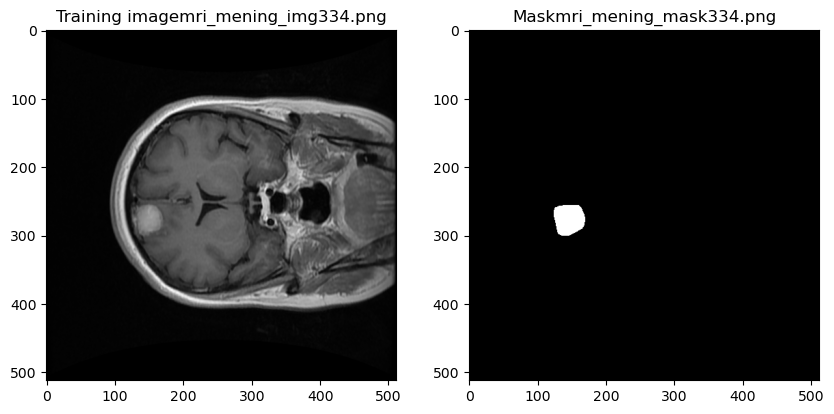

In [40]:
import torchvision
import torch
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage
import numpy as np
# Get an example from the training dataset
# example = 
# print(example)
# Convert pixel values and label to NumPy arrays
im = torchvision.io.decode_image(dataset_hf["train"]['pixel_values'][0],mode="GRAY")
im = torch.squeeze(im)
mask = torchvision.io.decode_image(dataset_hf["train"]['label'][0],mode="GRAY")
mask = torch.squeeze(mask)
print("Image/Mask dims", im.shape, mask.shape)
print("Image/Mask type", im.dtype, mask.dtype)
print("Image min, max", im.min(), im.max())
print("Mask min, max", mask.min(), mask.max())
print("Labels in mask", np.unique(mask))

# Visualize the image and mask side by side
fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(221)

# Display the training image
ax1.imshow(im, cmap='gray')
ax1.set_title('Training image' + dataset_hf["train"]['pixel_values'][0].split('/')[-1])

ax2 = fig.add_subplot(222)

# Display the corresponding mask
ax2.imshow(mask, cmap='gray')
ax2.set_title('Mask'+ dataset_hf["train"]['label'][0].split('/')[-1])


In [26]:
def IntersectionOverUnion(y_label,y_pred):
    
    # overlap (Logical AND)
    overlap = y_label*y_pred
    union = y_label+y_pred

    IOU = overlap.sum()/float(union.sum()+ 1e-9)
    return IOU